In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim

import numpy as np
import pickle
import pandas as pd
import csv

import random
import string

import re
import os

In [2]:
# convert the input lyrics into embedding vector
class LyricsProcess(object):
    def __init__(self, word_model, padding_size=500):
        
        self.wordmodel = gensim.models.Word2Vec.load(word_model)
        self.length = padding_size
        self.regex = re.compile('[%s]' % re.escape(string.punctuation))

    def process_lyrics(self, lyrics, regex):
        res = []
        for word in lyrics:
            word = word.lower()
            word = regex.sub('', word)
            res.append(word)
            
        return res

    def matrixize(self, lyrics):
        matrix = []
        for word in lyrics:
            if word in self.wordmodel.wv.vocab:
                matrix.append(np.ndarray.tolist(self.wordmodel.wv.__getitem__(word)))
        return matrix

    def padding(self, lyrics):
        if len(lyrics) <= self.length :
            padding_num =  self.length - len(lyrics)
            
            for j in range(padding_num):
                zero_row = np.zeros(100).tolist()
                lyrics.append(zero_row)
            return [np.expand_dims(np.array(lyrics), axis=2)]
        
        else:
            lyrics = lyrics[0:self.length]
            return [np.expand_dims(np.array(lyrics), axis=2)]
        
    def wordToVector(self, lyrics):
        lyric = self.process_lyrics(lyrics.replace("\n","").split(" "), self.regex)
        matrix = self.matrixize(lyric)
        
        return self.padding(matrix)

### Restore the trained model

In [3]:
# load the pre-trained model
class trained_CNN(object):
    # model_file is the filename of the saved meta graph 
    def __init__(self, model_file, word_model):
        tf.reset_default_graph() 
        self.sess = tf.Session()

        saver = tf.train.import_meta_graph(model_file + '.meta')
        saver.restore(self.sess, model_file)

        graph = tf.get_default_graph()

        self.input_x   = graph.get_tensor_by_name("input_x:0")
        self.predictions = graph.get_tensor_by_name("output/predictions:0")
        self.drop_out  = graph.get_tensor_by_name("dropout_keep_prob:0")

        self.wordmodel = LyricsProcess(word_model)
    
    # predict the genre on the input lyrics
    def predictionOne(self, lyric):
        genres = ['Country', 'Jazz', 'Metal', 'Pop', 'Rock']
        input_dict = {
            self.input_x: self.wordmodel.wordToVector(lyric),
            self.drop_out: 1.0
        }
        
        prediction = self.sess.run(self.predictions, input_dict)
        
        return genres[prediction[0]]


In [4]:
model_file = './runs/1544219414/checkpoints/model-3800'
word_model = 'wordTovector.model'
Y_testfile = "test.csv"

_cnn = trained_CNN(model_file, word_model)

INFO:tensorflow:Restoring parameters from ./runs/1544219414/checkpoints/model-3800


### Evaluation
#### 1. Random select a song from the test dataset, and predict its genre

In [5]:
def prediction(model, filename):
    df = pd.read_csv(filename)
    
    i = random.randint(0, len(df) - 1)
    
    song = df.iloc[i]['songName']
    genre = df.iloc[i]['genre']
    lyric = df.iloc[i]['lyrics']
    
    pred = model.predictionOne(lyric)
    
    print("Song: {}. The real genre is {}, the predicted genre is {}".format(song, genre, pred))

In [20]:
# predict the genre of one class selected randomly from the test dataset
prediction(_cnn, Y_testfile)

Song: On The Other Hand. The real genre is Country, the predicted genre is Country


#### 2. Calculate the accuracy of the testing dataset

In [51]:
def get_accuracy(model, filename):
    df = pd.read_csv(filename)
    count = 0
    
    for i in range(len(df)):
        label = df.iloc[i]['genre']
        lyric = df.iloc[i]['lyrics']
        pred = model.predictionOne(lyric)
        if label == pred:
            count += 1
   
    acc = count / len(df)
    return acc

get_accuracy(_cnn, Y_testfile)
print("the accuracy of testing dataset is {}%".format(acc * 100.0))

the accuracy of testing dataset is 82.28901734104046%


### Plot accuracy and loss 
train.txt and test.txt are the output saved files of train.ipynb

Those two files record how acc and loss change with steps during training/testing

In [1]:
# plot loss vs steps
train_loss = []
train_acc = []
train_steps = []

test_loss = []
test_acc = []
test_steps = []

with open("train.txt", 'r', encoding='UTF-8') as f:
    for line in f:
        temp = line.split(",")
        train_steps.append(int(temp[1]))
        train_loss.append(float(temp[2]))
        train_acc.append(float(temp[3]))

# print (train_loss)


with open("test.txt", 'r', encoding='UTF-8') as f:
    for line in f:
        temp = line.split(",")
        test_steps.append(int(temp[1]))
        test_loss.append(float(temp[2]))
        test_acc.append(float(temp[3]))        

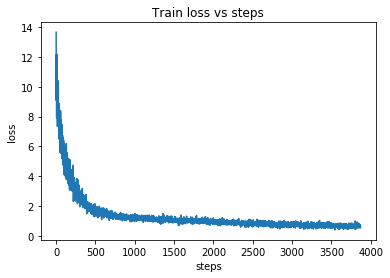

In [75]:
import matplotlib.pyplot as plt  

plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(train_steps, train_loss)
plt.title("Train loss vs steps")
plt.savefig('trainloss.png')
plt.show()

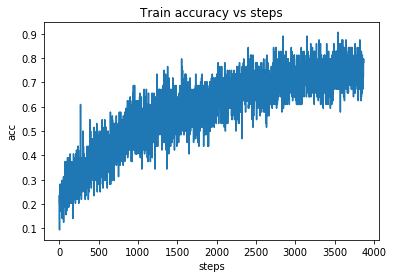

In [77]:
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(train_steps, train_acc)
plt.title("Train accuracy vs steps")
plt.savefig('trainacc.png')
plt.show()

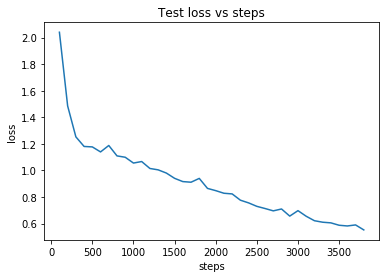

In [78]:
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(test_steps, test_loss)
plt.title("Test loss vs steps")
plt.savefig('testloss.png')
plt.show()

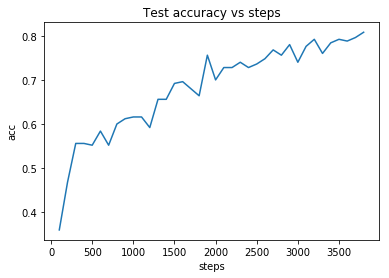

In [80]:
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(test_steps, test_acc)
plt.title("Test accuracy vs steps")
plt.savefig('testacc.png')
plt.show()

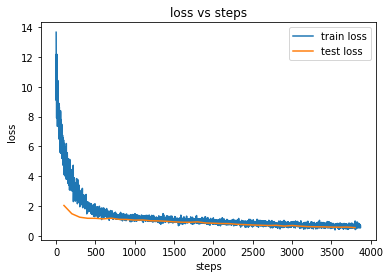

In [11]:
import matplotlib.pyplot as plt  

plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(train_steps, train_loss)
plt.plot(test_steps, test_loss)
plt.title("loss vs steps")
plt.savefig('loss.png')
plt.legend(['train loss', 'test loss'],loc='upper right')
plt.show()

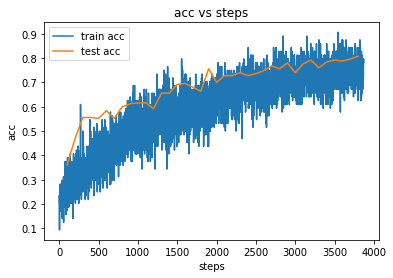

In [12]:
plt.xlabel('steps')
plt.ylabel('acc')
plt.plot(train_steps, train_acc)
plt.plot(test_steps, test_acc)
plt.title("acc vs steps")
plt.savefig('acc.png')
plt.legend(['train acc', 'test acc'],loc='best')
plt.show()